# Predicting Insurance Cost

![image.jpg](image.jpg)

# Table of Contents
1. [**Introduction**](#1)
2. [**Exploratory Data Analysis**](#2)
3. [**Feature Selection**](#3)
4. [**Build the Model**](#4)
5. [**Conclusion**](#5)

<a id='1'></a>
# Introduction
Predicting medical cost is an important task because it allows hospitals to predict revenue and plan necessary procedures needed by its patient population.

**Project Goal**     
In this project, we will be solving a regression problem. We are interested in how different characteristics relate to the **total medical cost**. We want to construct the best possible predictive model for the cost, given some information about the patient. 


The dataset has the following features:
* `age` - age of primary beneficiary
* `sex` - insurance contractor gender(female, male)
* `bmi` - body mass index
* `childeren` - number of children covered by health insurance
* `smoker` - smoking(yes, no)
* `region` - the beneficiary's residential area in the US (northeast, southeast, southwest, northwest)
* `charges` - individual medical costs billed by health insurance


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

np.random.seed(42)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

<a id='2'></a>
# Exploratory Data Analysis
Let's start with exploring the dataset.

In [2]:
# Load the data
insurance = pd.read_csv('insurance.csv')
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
insurance.shape

(1338, 7)

In [4]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


The dataset contains `7` columns and `1338` rows. We have 4 numerical columns and 3 categorical columns. 

In [5]:
insurance.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

The dataset does not contain any missing values. 

Let's look at the `charges` column, which is our outcome.

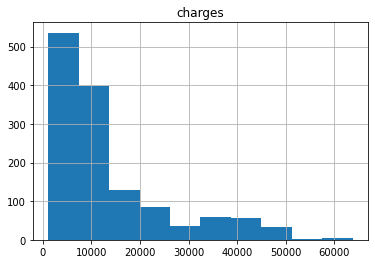

In [6]:
insurance.hist('charges')
plt.show()

The `charges` column is highly skewed to the right. Extremely costly insurance charges are more common than extremely small ones. This makes it unlikely that the errors in the model will truly be centered at zero. It might be worth it to log-transform the outcome. 

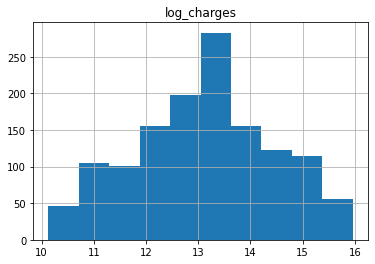

In [7]:
insurance['log_charges'] = np.log2(insurance['charges'])

# plot log transformed charges
insurance.hist('log_charges')
plt.show()

The log-transformed `charges` values are more centered, which is what we wanted. This makes it more likely that the errors will be unbiased.

We will now look at the numerical columns we have in the dataset. 

In [8]:
insurance.describe()

,age,bmi,children,charges,log_charges
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265,13.126590
std,14.049960,6.098187,1.205493,12110.011237,1.326597
min,18.000000,15.960000,0.000000,1121.873900,10.131695
25%,27.000000,26.296250,0.000000,4740.287150,12.210758
50%,39.000000,30.400000,1.000000,9382.033000,13.195685
75%,51.000000,34.693750,2.000000,16639.912515,14.022358
max,64.000000,53.130000,5.000000,63770.428010,15.960600


**Insights**    
* The minimum age of a primary beneficiary is `18` years. 
* The maximum number of children covered by the health insurance is `5`.
* We can confirm that the `charges` column is right-skewed with a mean of `13270.42` and a median of `9382.03`.
* The `log_charges` follows a normal distribution with mean of `13.13` and median of `13.20`

Let's now look at the categorical columns.

In [9]:
insurance.describe(include=['object'])

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


In [10]:
insurance['region'].value_counts()

southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64

The columns `sex` and `smoker` contain only 2 values whereas `region` contains 4 unique values, with `southeast` leading in number of patients.

Let's visualize the different categorical values we have. 

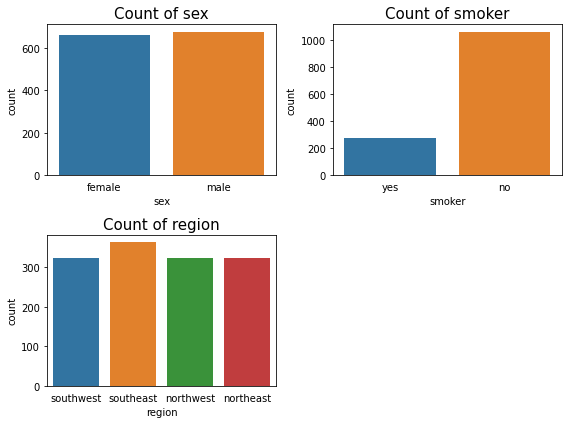

In [11]:
categorical = ['sex', 'smoker', 'region']
fig = plt.figure(figsize=(8,6))

for idx, col in enumerate(categorical):
    ax = plt.subplot(2, 2, idx+1)
    sns.countplot(x=insurance[col], ax=ax)
    # remove the ticks
    ax.tick_params(bottom=False)
    ax.set_title(f'Count of {col}', size=15)
fig.tight_layout() 
plt.show()

In [12]:
insurance.sex.value_counts()

male      676
female    662
Name: sex, dtype: int64

In [13]:
insurance.smoker.value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

* We have a slight difference between the number of male and female patients, with `676` being male and `662` being female. 
* The number of non smokers is higher with `1064` patients who do not smoke, compared to `274` patients who smoke. 

<a id='3'></a>
# Feature Selection
From the EDA we have performed above, we have a general understanding of the features we have. We are working with only `6` features, so we will start with all the features being potential candidates for our model.

Let us look at the correlations between the numerical features and the target. 

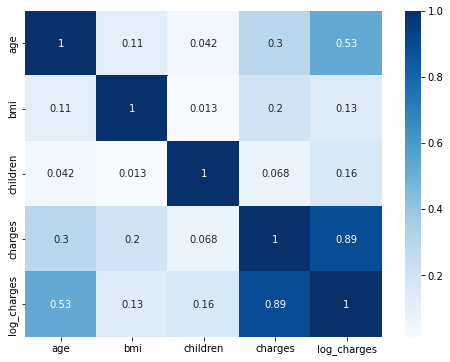

In [14]:
correlations = insurance.corr()
plt.figure(figsize=(8,6))
sns.heatmap(correlations, annot=True, cmap='Blues')
plt.show()

* `age` has `30%` correlation with `charges`
* `bmi` has a `20%` correlation with `charges`
* `children` has a `6.8%` correlation with charges, which is low. Let's visualize this relationship using a scatter plot


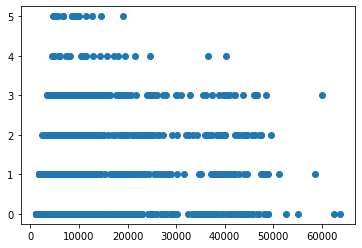

In [15]:
plt.scatter(insurance['charges'], insurance['children'])
plt.show()

The scatter plot shows that there is no linear relationship between `charges` and `children`, therefore we will drop this variable. 

We can now look at how the categorical features relate with the target variable. 

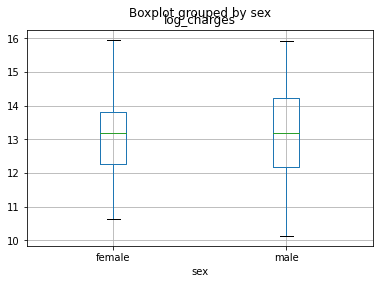

In [16]:
insurance.boxplot(column=['log_charges'], by='sex')
plt.show()

`Male` seem to have a wider distribution of charges compared to `women`.

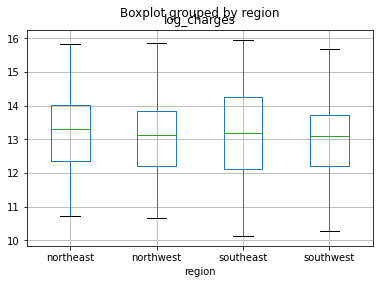

In [17]:
insurance.boxplot(column=['log_charges'], by='region')
plt.show()

There does't seem to be many appreciable differences between `regions`. However, the southeast region has a higher range. 

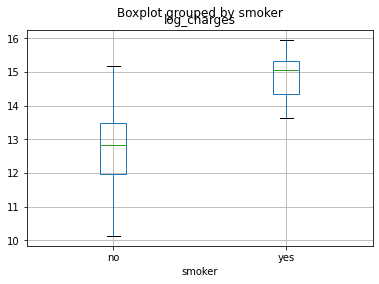

In [18]:
insurance.boxplot(column=['log_charges'], by='smoker')
plt.show()

`smokers` have much higher costs than the `non-smokers`

**Insights**    
Based on the univariate relationships shown above,
* `age`, 
* `bmi` and 
* `smoker` 

are positively associated with higher `charges`. We'll include these predictors in our final model. 

Before proceeding to building the model, we will replace the values in the `smoker` column with 0 and 1.

In [19]:
insurance['is_smoker'] = insurance['smoker'].apply(lambda x: 1 if x == 'yes'
                                                  else 0)
insurance.head()

,age,sex,bmi,children,smoker,region,charges,log_charges,is_smoker
0,19,female,27.900,0,yes,southwest,16884.92400,14.043448,1
1,18,male,33.770,1,no,southeast,1725.55230,10.752842,0
2,28,male,33.000,3,no,southeast,4449.46200,12.119415,0
3,33,male,22.705,0,no,northwest,21984.47061,14.424197,0
4,32,male,28.880,0,no,northwest,3866.85520,11.916945,0


<a id='4'></a>
# Build the Model
We will first split the data into train and test sets. 75% will be used for training and 25% of the data for testing

In [20]:
X = insurance[['age', 'bmi', 'is_smoker']]
y = insurance['log_charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size = 0.25)

In [21]:
# Training and checking model performance on training set
insurance_model = LinearRegression()
insurance_model.fit(X_train, y_train)

# Prediction using the model
y_pred = insurance_model.predict(X_train)

# score the model using MSE
mean_squared_error(y_train, y_pred)

0.447919196329921

In [22]:
# MSE on the original scale for the insurance charges
np.exp(mean_squared_error(y_train, y_pred))

1.565052228580154

In [23]:
# Coefficient of determination
r2_score(y_train, y_pred)

0.743333600772825

The training MSE for the model is `0.45` and is `1.57` on the original scale. The coefficient of determination indicates that the model can explain `74%` of the variation in the log-insurance charges. These preliminary results are promising, although optimistic.

## Residual Diagnostics
We now have a working predictive model for medical costs. Before we examine it more closely, we should check how well the assumptions of linear regression are met. 


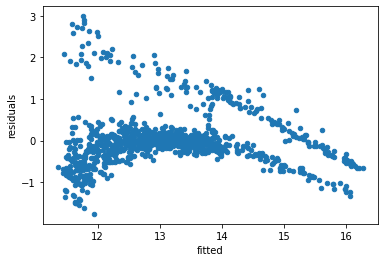

In [24]:
# visualization of residuals
check = pd.DataFrame()
check['residuals'] = y_train - y_pred
check['fitted'] = y_pred

check.plot.scatter(x='fitted', y='residuals')
plt.show()

The residuals suggest some violations to the assumptions of linear regression. As fitted values get larger, the residuals trend downward. We expect an even band, centered around zero. This does not necessary make the model predictions unusable, but it puts into question the linear regression assumptions.

## Interpret the Model
One of the best qualities about a linear model is that we can easily interpret what the estimated coefficients mean. The model gives us a way to discuss how changes in the predictors are related to changes in the outcome(without causing them).

From a hospital administrator's perspective, the regression coefficients might actually represent actionable plans to improve the efficiency of medical care. They may seek to reallocate resources to a particular hospital with particularly vulnerable patient population, based on the model interpretations.

In [25]:
insurance_model.coef_

array([0.0508618 , 0.01563733, 2.23214787])

**Insights**     
* A year increase in the subject is associated with a 0.05 increase in the log charges, holding smoking status and bmi constant. About a 5% increase in the charges on the regular scale. 
* a unit increase in the subject BMI is associated with a 0.021 increase in the log charges, holding smoking status and age constant. About a 1.5% increase in charges on the regular scale.
* A smoker is associated with a 2.23 increase in the log charges, holding the age and bmi constant. about a 930% increase in the charges on the regular scale. 

Note: we are not concerned about if these changes are statistically significant, so we don't know if these associations are truly non-zero. Our primary goal is prediction.

## Final Model Evaluation
Training error is almost always overly optimistic, so we shouldn't use it as the final judge of the model's predictive ability. Let's see how the model performs on the test data, which represents a set of new observations that it hasn't been trained on. 

In [26]:
test_pred = insurance_model.predict(X_test)
mean_squared_error(y_test, test_pred)

0.4529281560931768

In [27]:
np.exp(mean_squared_error(y_test, test_pred))

1.5729111783706105

<a id='5'></a>
# Conclusion
* The test MSE was about `0.453` while the training MSE was about `0.443`. In this case, the two errors match up pretty well, so we can conclude that the model is not overfit. 
* The residuals suggest that the model is predicting much lower costs for subjects who are actually charged much higher. Therefore, the model struggles with these higher costs.

As a whole, the model predictions are too conservative.
We might improve the model by including more complex terms in the regression, such as interactions or quadratic terms.